# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [42]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
CAT_AND_DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat_and_dog_in_same_image'
CATVSDOG_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["Cat", "Dog"]

### COMPUTE DEVICE (CPU/GPU) ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(CATVSDOG_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

Device: cuda


# Demo: ImageObject Class

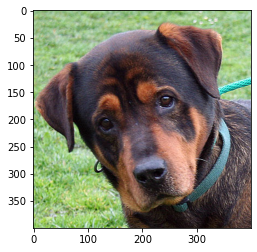

In [43]:
#pick random image
#random_image = get_image(CAT_IMG_PATH)
random_image = get_image(DOG_IMG_PATH)
#random_image = get_image(CAT_AND_DOG_IMG_PATH)

ImageObjectDemo = our_lime.ImageObject(random_image)
ImageObjectDemo.show()

# Image Classifier

In [44]:
#load CatVsDog weights into densenet architecture.
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

model.load_state_dict( torch.load(CATVSDOG_CLASSIFIER_WEIGHT_PATH, map_location = device) )

for param in model.parameters():
    param.requires_grad = False

model.eval()

#the data transformation used when training the CatVsDog classifier
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf

preprocess_transform = get_preprocess_transform()

# Demo: Explainer Class

In [45]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
explainer.segment_image(ImageObjectDemo)
#superpixels are saved
ImageObjectDemo.superpixels
print(np.shape(ImageObjectDemo.superpixels))

(400, 400)


# Demo: Generate Mask

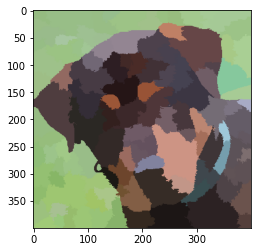

In [46]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

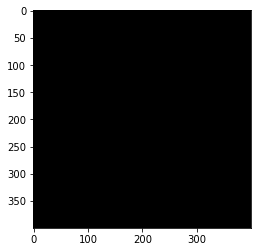

In [47]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

# Demo: Sample Superpixels

In [48]:
#create 3 samples
superpixel_samples, sampled_images = explainer.sample_superpixels(ImageObjectDemo, 4)

<class 'list'>
<class 'numpy.ndarray'>
(400, 400, 3)


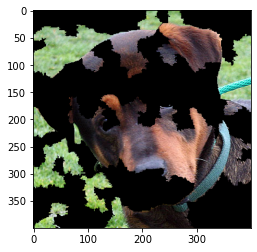

In [49]:
print(type(sampled_images))
#showing first sample
print(type(sampled_images[0]))
print(np.shape(sampled_images[0]))
plt.imshow(sampled_images[0])

# Demo: BlackBox IO

In [50]:
# blackbox output on sampled images
blackbox_out = explainer.map_blaxbox_io(sampled_images)
print(np.mean(blackbox_out, axis=0))
#blackbox output on original image
blackbox_out = explainer.map_blaxbox_io((ImageObjectDemo.original_image,))
print(blackbox_out)



[0.5707933 0.4292067]
[[9.306033e-04 9.990694e-01]]


# Demo: Explain Image

[1 0]
[(0, -0.019113589985887684), (1, -0.025186164787606487), (2, -0.002249997480521954), (3, -0.0167601160051849), (4, 0.005220967938203379), (5, -0.003930772658485321), (6, 0.021393663416616762), (7, -0.006314695305606341), (8, -0.00902217291277053), (9, -0.008020942496958458), (10, 0.00957703646535559), (11, 0.004630806423641629), (12, 0.00015380144926314946), (13, -0.0030121965408862073), (14, 0.007300650192556984), (15, 0.003377991650179943), (16, 0.0008389621408308762), (17, -0.0021295415682877675), (18, 0.01862023109629742), (19, 0.009360505761097192), (20, 0.004067242949009467), (21, -0.0011218654114956033), (22, 0.012315432734222), (23, 0.018910899219583492), (24, 0.008039469725628499), (25, 0.004010561761615358), (26, 0.011860120680420081), (27, -0.0011861200748226036), (28, -0.022611980683854577), (29, 0.006245473274966182), (30, -0.009820801017479137), (31, 0.009430733309990036), (32, 0.00457452073839002), (33, -0.004580814247484322), (34, -0.008354112591055184), (35, 0.02

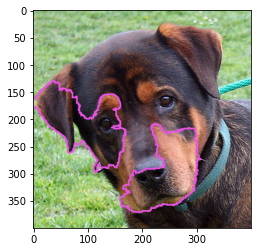

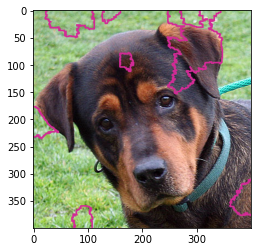

In [51]:
explainer.explain_image(ImageObjectDemo, 1000, classes, top_labels = 2, num_superpixels = 10)
